# A Machine Learning Approach to Image Processing

<p><b>Quantitative Big Imaging</b> ETHZ: 227-0966-00L</p>
    
<p><b>Part 2</b></p>

<p style="font-size:1em;">March 18, 2021</p>
<br /><br />
<p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
<p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>

## Loading some modules

Let's load a collection of modules for this part.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.io import imread
import plotsupport as ps
from sklearn.metrics import roc_auc_score
import pandas as pd
from collections import OrderedDict
from sklearn.metrics import roc_curve

%matplotlib inline

## How to approach the analysis
Segmentation and all the steps leading up to it are really a specialized type of learning problem. 

Let's look at an important problem for electron microscopy imaging...

Identifying the mitochondria in the images like the one to the left in the figures below.

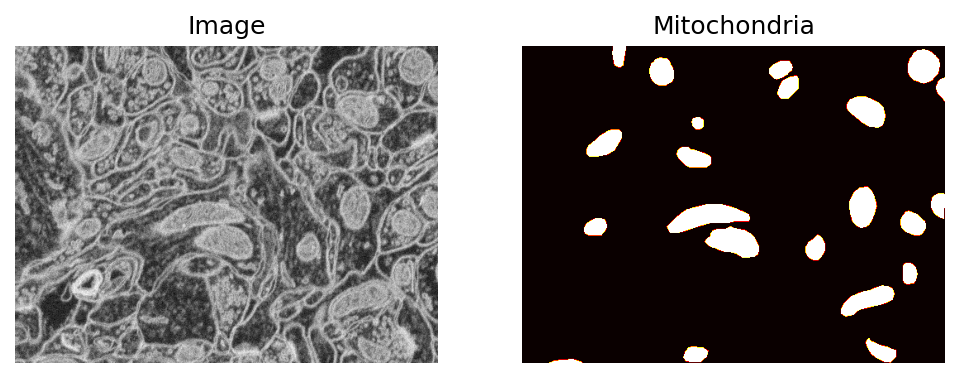

In [15]:
cell_img = (255-imread("data/em_image.png")[::2, ::2])/255.0
cell_seg = imread("data/em_image_seg.png")[::2, ::2]>0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
ax1.imshow(cell_img, cmap='gray'); ax1.set_title('Image');        ax1.axis('off');
ax2.imshow(cell_seg, cmap='hot');  ax2.set_title('Mitochondria'); ax2.axis('off');

We want to identify which class each pixel belongs to.

What does identify mean?
- Classify the pixels in a mitochondria as _Foreground_
- Classify the pixels outside of a mitochondria as _Background_

This is a really tedious task and we want to automatize it. Here, segmentation is a good approach. The question is now how we can achieve this.

## How do we quantify this?

<div class="alert alert-block alert-success">
    
- __True Positive__ values in the mitochondria that are classified as _Foreground_
- __True Negative__ values outside the mitochondria that are classified as _Background_

</div>




<div class="alert alert-block alert-danger">
    
- __False Positive__ values outside the mitochondria that are classified as _Foreground_
- __False Negative__ values in the mitochondria that are classified as _Background_

</div>

We can then apply a threshold to the image to determine the number of points in each category

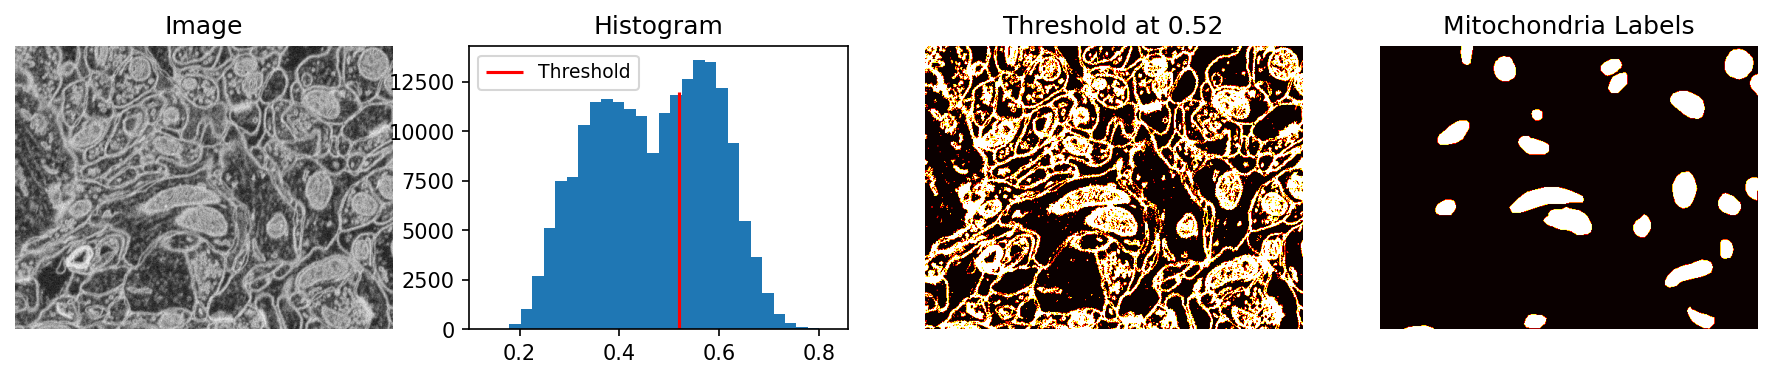

In [16]:
thresh     = 0.52 
thresh_img = cell_img > thresh # Apply a single threshold to the image

# Visualization
fig, ax = plt.subplots(1, 4, figsize=(15, 2.5), dpi=150)
ax[0].imshow(cell_img, cmap='gray');  ax[0].set_title('Image');    ax[0].axis('off')
ax[1].hist(cell_img.ravel(),bins=30); ax[1].set_title('Histogram')
ax[1].vlines(thresh,ymin=0,ymax=12000,color='r',label='Threshold'); ax[1].legend(fontsize=9)
ax[2].imshow(thresh_img, cmap='hot');   ax[2].set_title('Threshold at {0}'.format(thresh)); ax[2].axis('off')
ax[3].imshow(cell_seg,   cmap='hot');   ax[3].set_title('Mitochondria Labels');             ax[3].axis('off');

In this example we can see that it is clearly not sufficient to apply a single threshold as we have tried before. When we compare the thresholded image to the provided mask, we can see the that there are plenty more structures marked as foreground and also that there are holes within the mitochondria.

## Check the performance of the thresholding

Let's create a confusion matrix to visualize the performance of the segmentation. A first step is to compute how many hits and misses our segmentation resulted in. In particual, looking at the four different cases that can occur in a binarization. 

In [17]:
# Suport function for the plot labels
def tp_func(real_img_idx, pred_img_idx):
    if real_img_idx == 1 and pred_img_idx == 1:
        return 'True Positive','#009933'
    if real_img_idx == 0 and pred_img_idx == 0:
        return 'True Negative','#009933'
    if real_img_idx == 0 and pred_img_idx == 1:
        return 'False Positive','#cc0000'
    if real_img_idx == 1 and pred_img_idx == 0:
        return 'False Negative','#cc0000'

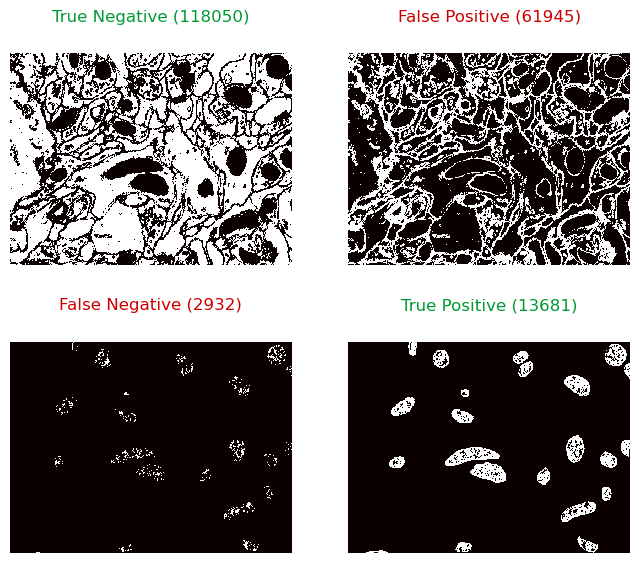

In [18]:
out_results = {}
fig, m_ax = plt.subplots(2, 2, figsize=(8, 7), dpi=100)
for real_img_idx, n_ax in zip([0, 1], m_ax):
    for pred_img_idx, c_ax in zip([0, 1], n_ax):
        match_img = (thresh_img == pred_img_idx) & (cell_seg == real_img_idx)
        (tp_title,color) = tp_func(real_img_idx, pred_img_idx)
        c_ax.matshow(match_img, cmap='hot')
        out_results[tp_title] = np.sum(match_img)
        c_ax.set_title("{0} ({1})".format(tp_title,out_results[tp_title]),color=color)
        c_ax.axis('off')

## The confusion matrix (revisited)

From the counts in the previus slide, we can now create a [Confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) and also look at the combined image of all the cases. In the hit map we can see white and gray as true segmentation and blue and magenta as false segmentations.

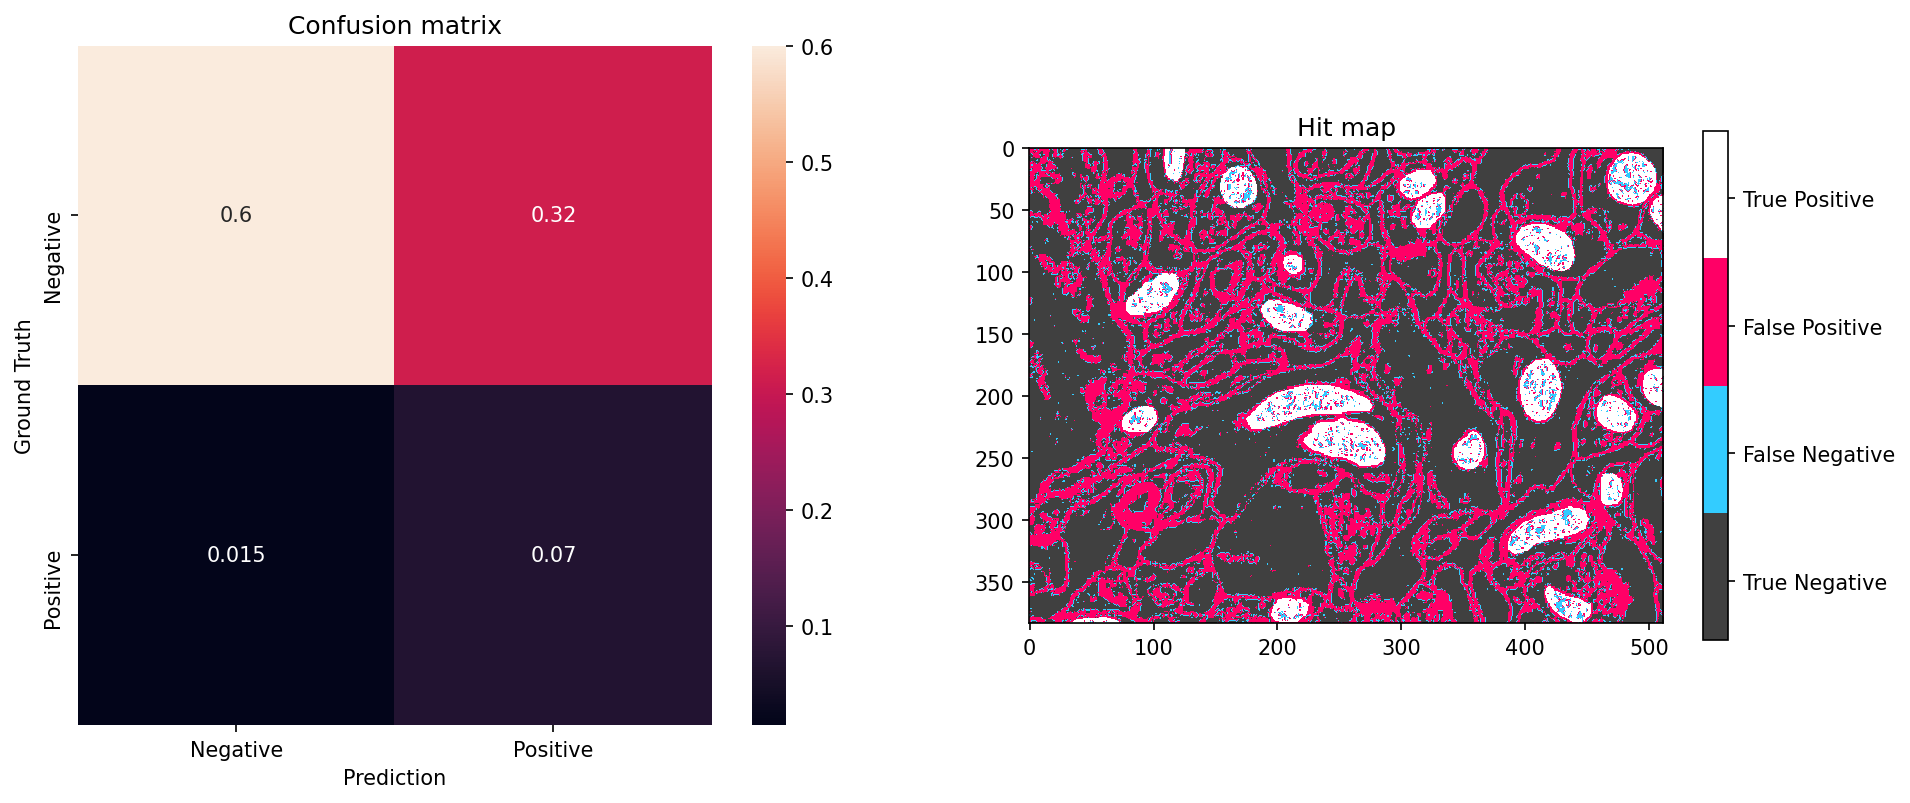

In [19]:
fig,ax=plt.subplots(1,2,figsize=(15,6),dpi=150)
ps.showHitMap(cell_seg,thresh_img,ax=ax) # this is a handy support function provided with the notebook

## Apply Precision and Recall

We can use two further metrics to measure the performance of a segmentation method. These are based on the information in the confusion matrix like

- __Recall__ (sensitivity)  $$\frac{TP}{TP+FN}$$

This is the sum the true positive relative to the number of positives in the mask or also as written here the sum of true positives and false negatives. Recall tells us how good the method is to find the correct label within the mask.

- __Precision__            $$\frac{TP}{TP+FP}$$

This is the sum of true positives relative to the total number of positives provided by our segmentation method. The precision tells us how much our method over segments the image.

Both recall and precision are scalar numbers in the interval $0<m\leq1$ where '1' is the ideal condition.

Let's compute precision and recall for our mitochonria example.

In [20]:
print('Recall: {0:0.2f}'.format(out_results['True Positive'] /
                         (out_results['True Positive']+out_results['False Negative'])))
print('Precision: {0:0.2f}'.format(out_results['True Positive'] /
                            (out_results['True Positive']+out_results['False Positive'])))

Recall: 0.82
Precision: 0.18


This result tells us that our segmentation was relatively good at finding the mitochondria, but also that this happened at the cost of many false positives. 

# [Reciever Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

ROC curves are a very common tool for analyzing the performance of binary classification systems and there are a large number of tools which can automatically make them. 

- The concept of the ROC curve was [first developed for WW2 soldiers detecting objects in battlefields using radar](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#History)). 

- As we saw before, for a single threshold value 0.5, we were able to compute a single recall and precision. 

- The ROC shows the releation between recall and precision for a segmentation model.

Let's compute the hit and miss statistics...

If we want to make an ROC curve we take a number of threshold values and compute the corresponding precision and recall values for each threshold.  In the example below we scan threshold values from 0.1 to 0.9 and compute the hit and miss statistics to calculate the precision and recall.

In [21]:
out_vals = []
for thresh_val in np.linspace(0.1, 0.9):
    thresh_img = cell_img > thresh_val
    for real_img_idx in [0, 1]:
        for pred_img_idx in [0, 1]:
            match_img = (thresh_img == pred_img_idx) & (
                cell_seg == real_img_idx)
            tp_title = tp_func(real_img_idx, pred_img_idx)
            out_results[tp_title] = np.sum(match_img)
    out_vals += [
        OrderedDict(
            Threshold = thresh_val,
            Recall    = out_results['True Positive'] / (out_results['True Positive']+out_results['False Negative']),
            Precision = (out_results['True Positive'] / (out_results['True Positive']+out_results['False Positive'])),
            False_Positive_Rate = (out_results['False Positive'] / (out_results['False Positive']+out_results['True Negative'])),
            **out_results
        )]

roc_df = pd.DataFrame(out_vals)
roc_df.head(3)

,Threshold,Recall,Precision,False_Positive_Rate,True Negative,False Positive,False Negative,True Positive,"(True Negative, #009933)","(False Positive, #cc0000)","(False Negative, #cc0000)","(True Positive, #009933)"
0,0.100000,0.823512,0.180903,0.344148,118050,61945,2932,13681,0,179995,0,16613
1,0.116327,0.823512,0.180903,0.344148,118050,61945,2932,13681,0,179995,0,16613
2,0.132653,0.823512,0.180903,0.344148,118050,61945,2932,13681,0,179995,0,16613


... and plot the table.

## Making ROC Curves Easier
Here we show how it is done with scikit-image. 

Another way of showing the ROC curve (more common for machine learning rather than medical diagnosis) is using the True positive rate and False positive rate

- __True Positive Rate__ (recall)= $TP/(TP+FN)$
- __False Positive Rate__ = $FP/(FP+TN)$

These show very similar information with the major difference being the goal is to be in the upper left-hand corner. Additionally random guesses can be shown as the slope 1 line. Therefore for a system to be useful it must lie above the random line.

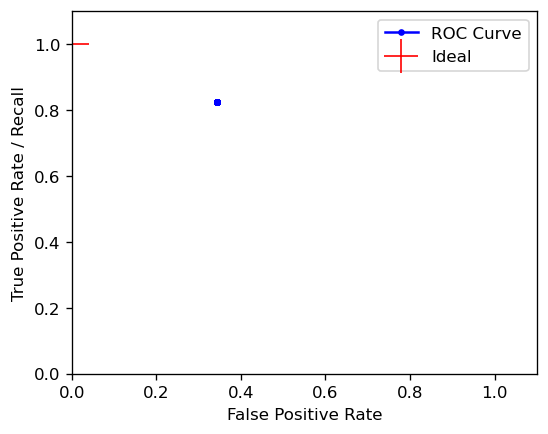

In [52]:
fig, ax1 = plt.subplots(1, 1, dpi=120,figsize=(5,4))
ax1.plot(roc_df['False_Positive_Rate'], roc_df['Recall']  , 'b.-', label='ROC Curve')
ax1.plot(0, 1.0, 'r+', markersize=20, label='Ideal'); ax1.set_xlim(0, 1.1); ax1.set_ylim(0, 1.1);
ax1.set_ylabel('True Positive Rate / Recall')
ax1.set_xlabel('False Positive Rate')
ax1.legend(loc='upper right');

### ROC curve for mitochondria image segmentation

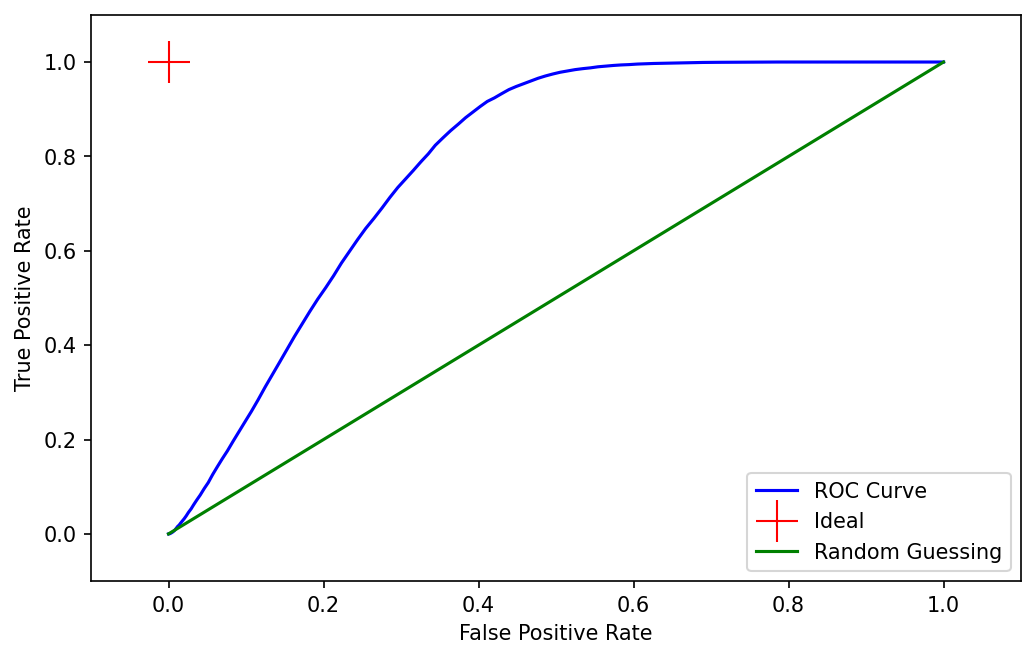

In [25]:
fpr, tpr, thresholds = roc_curve(cell_seg.ravel().astype(int),
                                 cell_img.ravel())

fig, ax1 = plt.subplots(1, 1, dpi=150,figsize=(8,5))
ax1.plot(fpr, tpr, 'b.-', markersize=0.01,  label='ROC Curve')
ax1.plot(0.0, 1.0, 'r+', markersize=20, label='Ideal')
ax1.plot([0, 1], [0, 1], 'g-', label='Random Guessing')
ax1.set_xlim(-0.1, 1.1); ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc=0);

## Explore the impact of different filters on the ROC

We have already seen what the ROC curve looks like for the original data. Some weeks ago we learnt about a lot of filters and now it is time to see how these can be used in an attempt to improve the ROC. In this example we will compare the unfiltered image to:
- Gaussian filter ($\sigma=2$)
- Difference of Gaussian $x-G_{sigma=3}*x$
- Median size 3x3
And see what performance improvements we can achieve

Let's produce some filtered images:

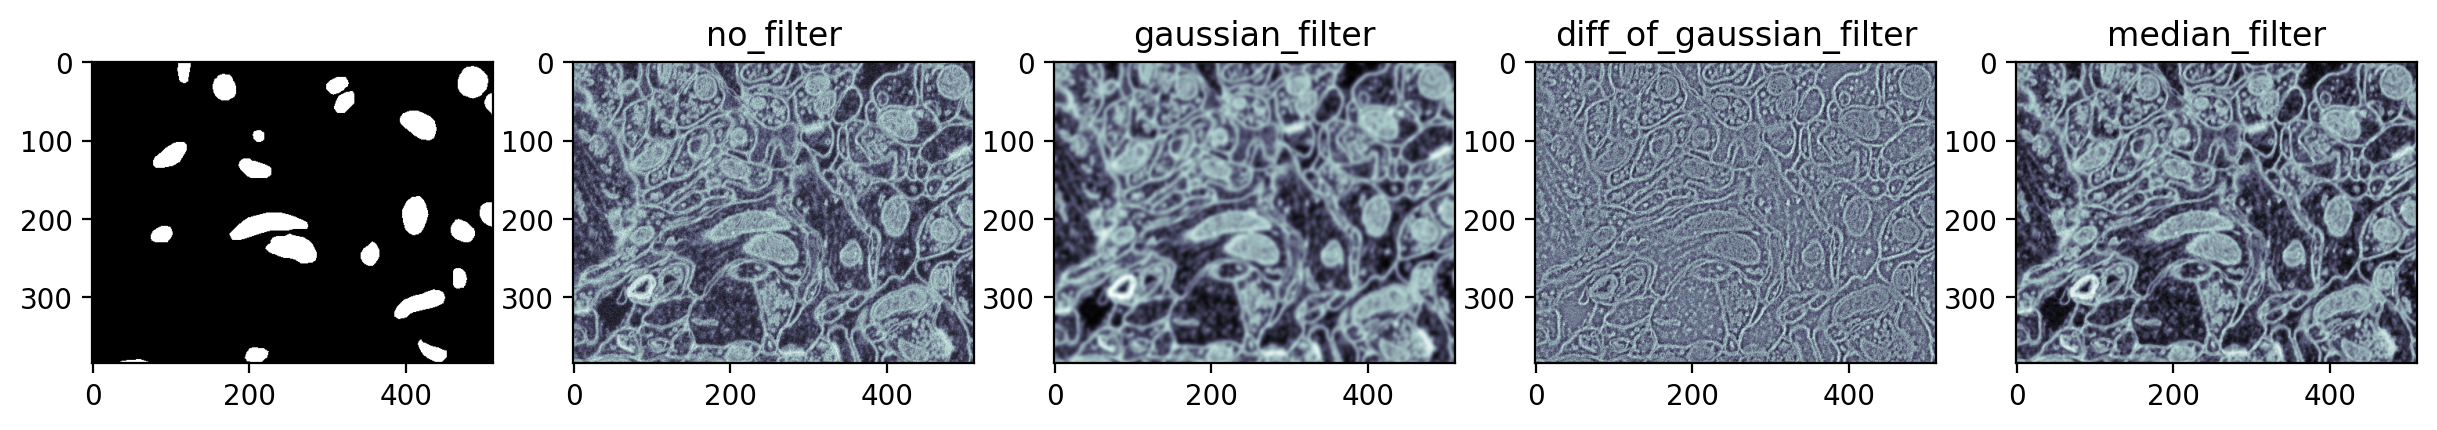

In [26]:
from skimage.filters import gaussian, median

def no_filter(x):               return  x
def gaussian_filter(x):         return  gaussian(x, sigma=2)
def diff_of_gaussian_filter(x): return  x-gaussian(x, sigma=3)
def median_filter(x):           return  median(x, np.ones((3, 3)))

fig, m_axs = plt.subplots(1, 5, figsize=(15, 3), dpi=200)
m_axs[0].imshow(cell_seg, cmap='gray')
for c_filt, c_ax in zip([no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter], m_axs[1:]):
    c_ax.imshow(c_filt(cell_img), cmap='bone')
    c_ax.set_title(c_filt.__name__)

### ROC curves of filtered images

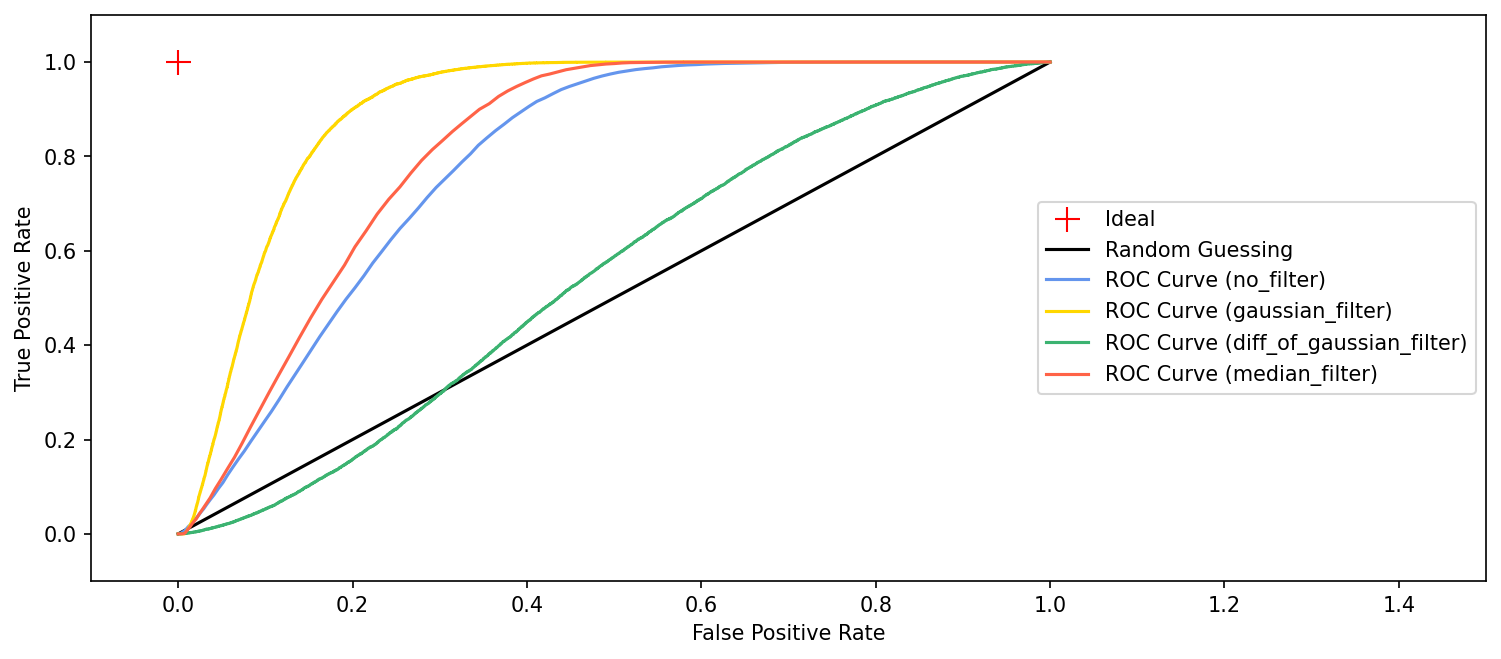

In [81]:
fig, ax1 = plt.subplots(1, 1,figsize=(12,5), dpi=150)

ax1.plot(0.0, 1.0, 'r+', markersize=12, label='Ideal')
ax1.plot([0, 1], [0, 1], 'k-', label='Random Guessing')

colors = ['cornflowerblue','gold','mediumseagreen','tomato']
for color,c_filt in zip(colors,[no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter]):
    fpr, tpr, thresholds = roc_curve(cell_seg.ravel().astype(int), c_filt(cell_img).ravel())
    ax1.plot(fpr, tpr, '-', markersize=0.01, label='ROC Curve ({})'.format(c_filt.__name__),color=color)

# Decorations
ax1.set_xlim(-0.1, 1.5); ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('False Positive Rate'); ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="center right", fontsize=10);

## Area Under the Curve (AUC)

We can then use this ROC curve to compare different filters (or even entire workflows), if the area is higher the approach is better.

Different approaches can be compared by _Area Under the Curve_ (AUC) which is a scalar.

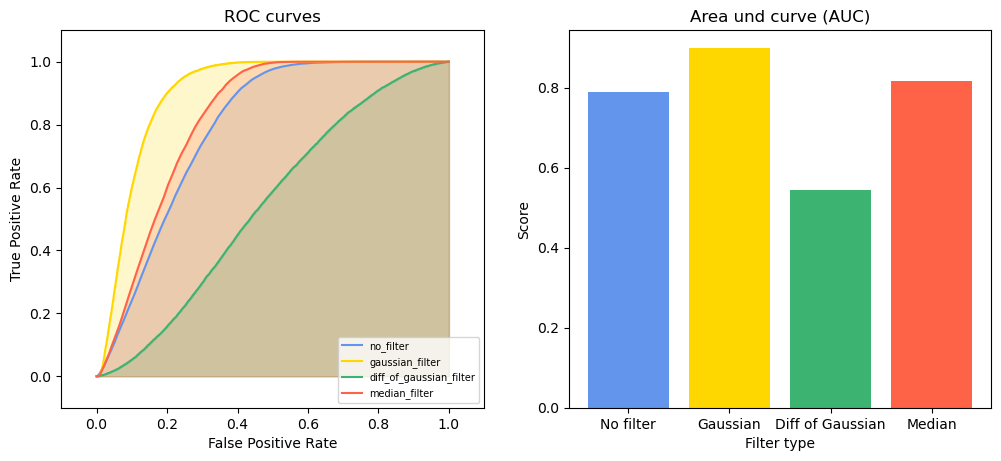

In [64]:
fig, ax = plt.subplots(1, 2,figsize=(12,5), dpi=100)
colors = ['cornflowerblue','gold','mediumseagreen','tomato']
scores = []
for color, c_filt in zip(colors,[no_filter, gaussian_filter, diff_of_gaussian_filter, median_filter]):
    fimg = c_filt(cell_img).ravel()
    fpr, tpr, thresholds = roc_curve(cell_seg.ravel().astype(int), fimg)
    scores.append(roc_auc_score(cell_seg.ravel().astype(int),  fimg))
    ax[0].plot(fpr, tpr, '-', markersize=0.01, color=color,label='{}'.format(c_filt.__name__))
    ax[0].fill_between(fpr, tpr, 0, alpha=0.2, color=color)

ax[0].set_xlim(-0.1, 1.1); ax[0].set_ylim(-0.1, 1.1)
ax[0].set_xlabel('False Positive Rate'); ax[0].set_ylabel('True Positive Rate'); ax[0].set_title('ROC curves')
ax[0].legend(loc="lower right", fontsize=7);
names = ['No filter', 'Gaussian', 'Diff of Gaussian', 'Median']
ax[1].bar(names,scores, color=colors); plt.xlabel('Filter type'),ax[1].set_ylabel('Score'); ax[1].set_title('Area und curve (AUC)');

Armed with these tools we are ready to analyze the performance of the segmentation methods we develop to solve our image analysis tasks.

# Segmenting multiple phases

## Multiple Phases example: Segmenting Shale

- Shale provided from _Kanitpanyacharoen, W. (2012). Synchrotron X-ray Applications Toward an Understanding of Elastic Anisotropy._

- Here we have a shale sample measured with X-ray tomography with three different phases inside (clay, rock, and air).
- The model is that because the chemical composition and density of each phase is different they will absorb different amounts of x-rays and appear as different brightnesses in the image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.io import imread
%matplotlib inline

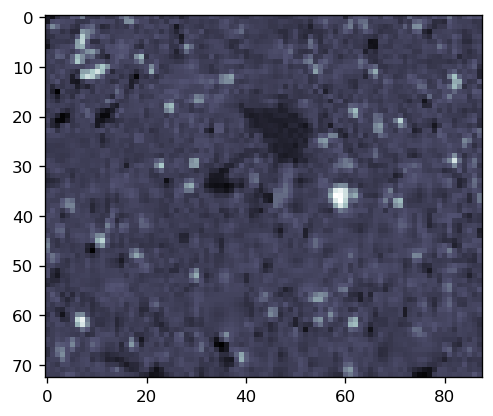

In [27]:
shale_img = imread("figures/ShaleSample.jpg")/255.0
fig, ax1 = plt.subplots(1, 1, dpi=120)
ax1.imshow(shale_img, cmap='bone');

### Finding three categories
Let's take a look at the histogram as always when we face a segmentation task...

Ideally we would derive 3 values for the thresholds based on a model for the composition of each phase and how much it absorbs, but that is not always possible or practical.
- While there are 3 phases clearly visible in the image, the histogram is less telling (even after being re-scaled).

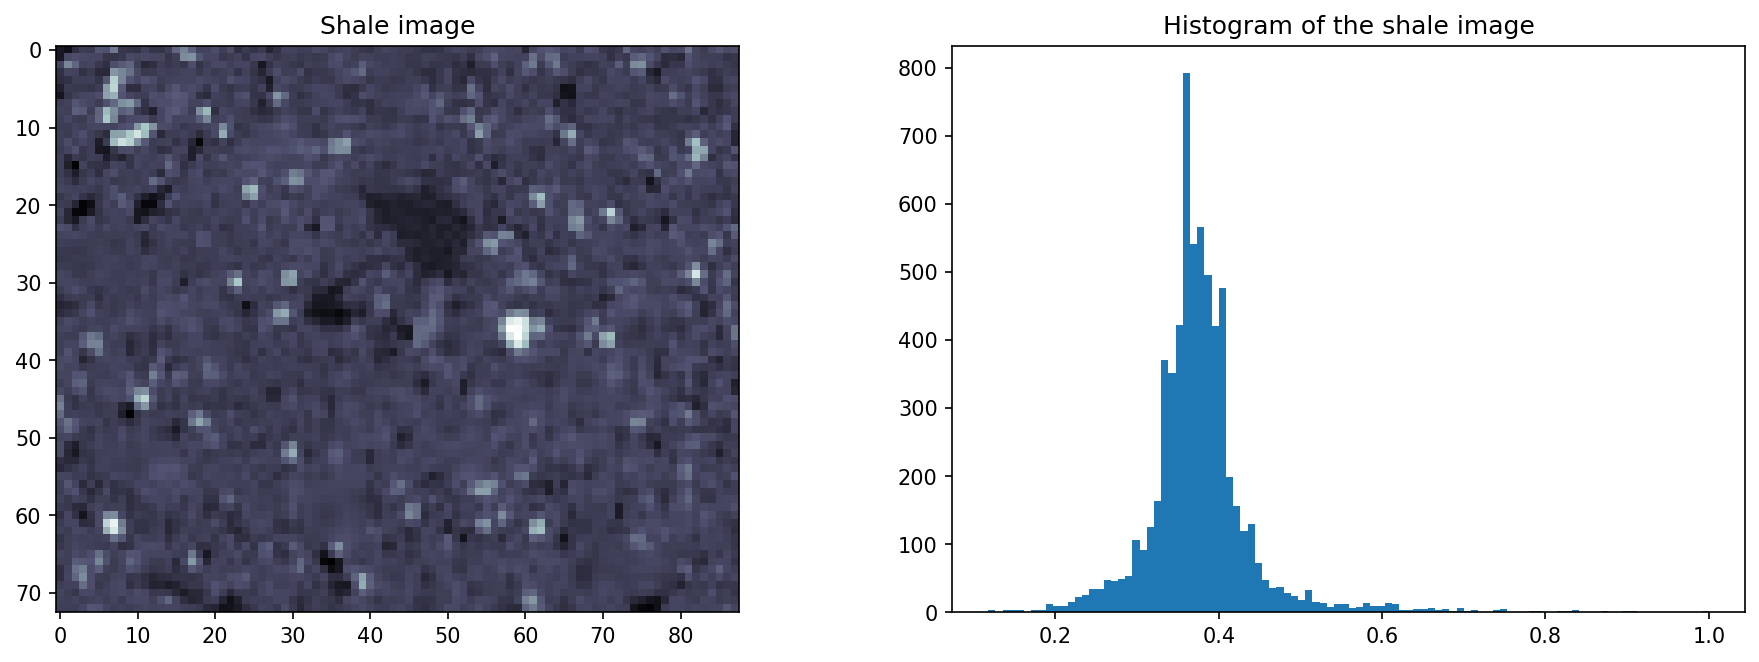

In [29]:
fig, ax=plt.subplots(1,2, figsize=(15,5),dpi=150)
ax[0].imshow(shale_img, cmap='bone'), ax[0].set_title('Shale image')
ax[1].hist(shale_img.ravel(), 100); ax[1].set_title('Histogram of the shale image');

# Multiple Segmentations

For this exercise we choose arbitrarily 3 ranges for the different phases and perform visual inspection

The relation can explicitly be written out as
$$ I(x) = 
\begin{cases}
\text{Void}, & 0 \leq x \leq 0.3  \\
\text{Clay}, & 0.3 < x \leq 0.5 \\
\text{Rock}, & 0.5 < x
\end{cases}$$

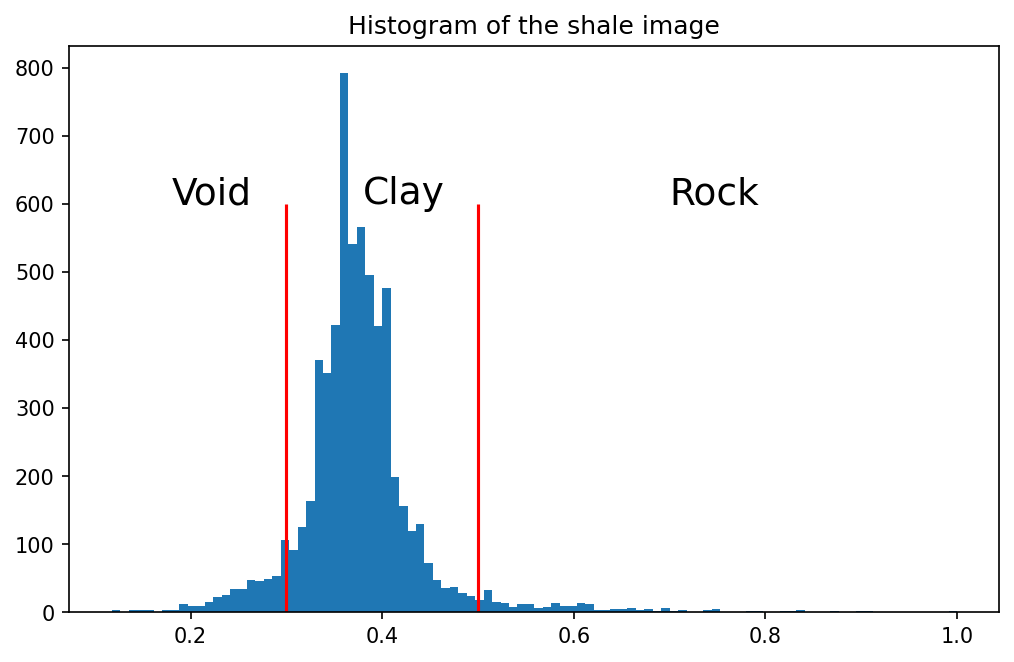

In [31]:
fig, ax=plt.subplots(1,1, figsize=(8,5),dpi=150)
ax.hist(shale_img.ravel(), 100); ax.set_title('Histogram of the shale image');

thresholds = [0.3, 0.5]
ax.vlines(thresholds,ymin=0,ymax=600,color='r');
fs=18; ypos=600; ax.text(0.18,ypos,'Void', fontsize=fs), ax.text(0.38,ypos,'Clay', fontsize=fs),ax.text(0.7,ypos,'Rock', fontsize=fs);


## Segmentation result

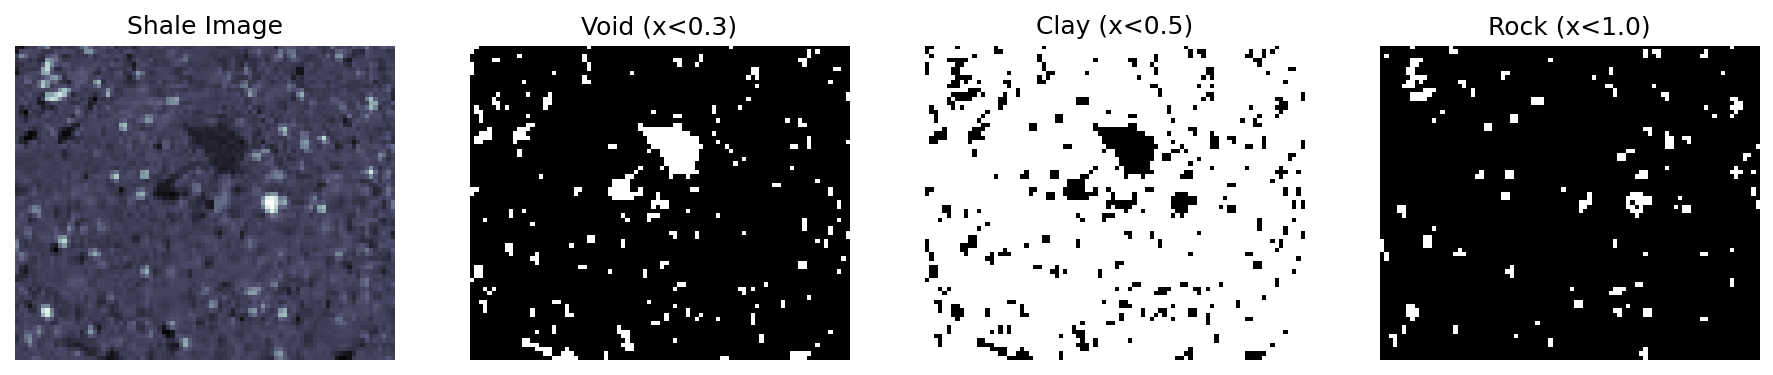

In [155]:
fig, m_axs = plt.subplots(1, 4, dpi=150, figsize=(15, 5))
m_axs[0].imshow(shale_img, cmap='bone')
m_axs[0].set_title('Shale Image'); m_axs[0].axis('off')
used_vox = np.zeros_like(shale_img).astype(np.uint8)
for c_ax, c_max, c_title in zip(m_axs[1:], [0.3, 0.5, 1.0], ['Void', 'Clay', 'Rock']):
    c_slice = (shale_img < c_max)-used_vox
    c_ax.imshow(c_slice, cmap='bone')
    used_vox += c_slice
    c_ax.axis('off')
    c_ax.set_title('{0} (x<{1:0.1f})'.format(c_title, c_max))

Segmenting multiple phases is a non-trivial problem. In particular, when the edges in the image as smooth and at low SNR. We will look into these problems next week.

# Implementation of thresholding

The implementations of basic thresholds and segmentations is very easy since it is a unary operation of a single image
$$ f(I(\vec{x})) $$

How is this implemented with using a programming language?


In mathematical terms this is called a map and since it does not require information from neighboring voxels or images it can be calculated for each point independently (_parallel_). Filters on the other hand almost always depend on neighboring voxels and thus the calculations are not as easy to seperate. 

## Implementation using script languages

### Python (numpy) and Matlab
The simplest is a single threshold in numpy and Matlab: 
```matlab
thresh_img = gray_img > thresh
```

A more complicated threshold: 
```
thresh_img = (gray_img > thresh_a) & (gray_img < thresh_b)
```


### Python
The task is slightly more complicated when you use standard python. Here, you have to define a mapping function with a lambda to perform the thresholding.
```python
thresh_img = map(lambda gray_val: gray_val>thresh, gray_img)
```

## Implementation using traditional programming languages
In traditional programming languages you have to write some moer code as there are no predefined functions that operate directly on arrays. This means, you'll have to implement the loops yourself.

### Java
```java
boolean[] thresh_img = new boolean[x_size*y_size*z_size];
for(int x=x_min;x<x_max;x++)
  for(int y=y_min;y<y_max;y++)
    for(int z=z_min;z<z_max;z++) {
      int offset=(z*y_size+y)*x_size+x;
      thresh_img[offset]=gray_img[offset]>thresh;
    }
```
  
### C/C++

```c++
bool* thresh_img = malloc(x_size*y_size*z_size * sizeof (bool));

for(int x=x_min;x<x_max;x++)
  for(int y=y_min;y<y_max;y++)
    for(int z=z_min;z<z_max;z++) {
      int offset=(z*y_size+y)*x_size+x;
      thresh_img[offset]=gray_img[offset]>thresh;
    }
```

### Alternative solution
- Image are stored as a sequence of numbers, not matter the number of dimensions. 
- The pixel neighborhood is not considered.
- A single loop can be used! 

# [Morphology](http://scikit-image.org/docs/dev/api/skimage.morphology.html)
We can now utilize information from neighborhood voxels to improve the results. 

These steps are called morphological operations. 

Like filtering the assumption behind morphological operations are
- nearby voxels in __real__ images are related / strongly correlated with one another 
- noise and imaging artifacts are less spatially correlated. 

Therefore these imaging problems can be alleviated by adjusting the balance between local and neighborhood values.

## Noisy segmentation
We return to the original image of a cross:

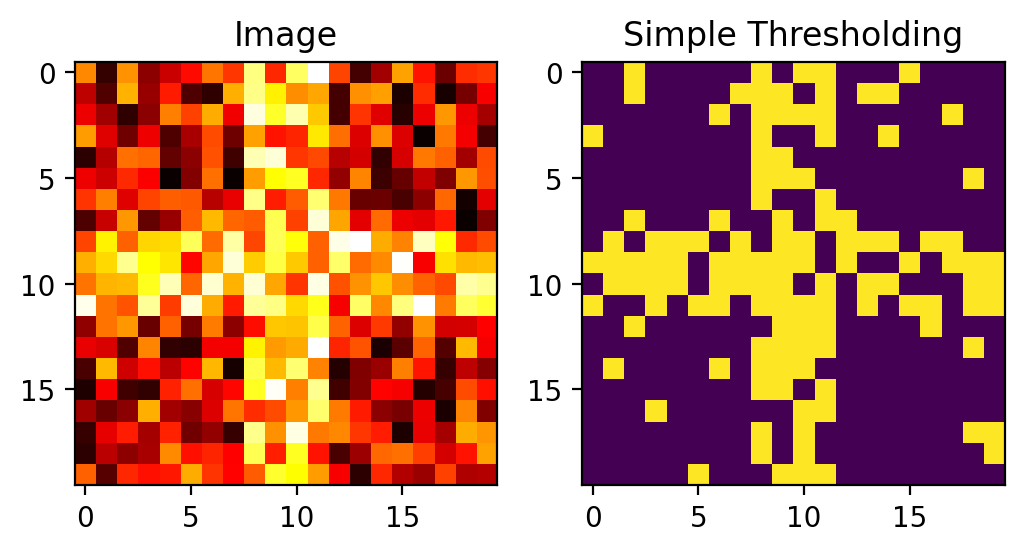

In [37]:
nx = 20
ny = 20
xx, yy = np.meshgrid(np.linspace(-10, 10, nx),
                     np.linspace(-10, 10, ny))
np.random.seed(2018)
cross_im = 1.1*((np.abs(xx) < 2)+(np.abs(yy) < 2)) + \
    np.random.uniform(-1.0, 1.0, size=xx.shape)

thimg = cross_im > 0.8 # Let's apply a threshold

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.5), dpi=200)
ax1.imshow(cross_im, cmap='hot')
ax1.set_title('Image')
ax2.imshow(thimg)
ax2.set_title('Simple Thresholding');

We have a lot of misclassified pixels here!

## Fundamentals: Neighborhood
A neighborhood consists of the pixels or voxels which are of sufficient proximity to a given point. There are a number of possible definitions which largely affect the result when it is invoked.   
- A large neighborhood performs operations over larger areas / volumes
 - Computationally intensive
 - Can _smooth_ out features
- A small neighborhood performs operations over small areas / volumes
 - Computationally cheaper
 - Struggles with large noise / filling large holes

### Why do we need neighborhods

The neighborhood is important for a large number of image and other (communication, mapping, networking) processing operations:
- filtering
- morphological operations
- component labeling
- distance maps
- image correlation based tracking methods

It is often called structuring element (or ```selem``` for sort / code), but has exactly the same meaning

### Fundamentals: Neighbors in 2D

For standard image operations there are two definitions of neighborhood. 

```{figure} figures/se_r1.pdf
---
scale: 25%
---
4-connected pixel neighborhood for 2D images.
```

```{figure} figures/se_rsqrt2.pdf
---
scale: 25%
---
8-connected pixel neighborhood for 2D images.
```

<table>
<tr>
<th>4-connected</th>
<th>8-connected</th>    
</tr>
<tr>
<td><img src="figures/se_r1.svg" style="width:150px"/></td>
<td><img src="figures/se_rsqrt2.svg" style="width:150px"/></td>
</tr>
</table>

The 4 and 8 adjacent neighbors shown below. Given the blue pixel in the center the red are the 4-adjacent and the red and green make up the 8 adjacent. We expand beyond this to disk, cross, vertical and horizontal lines

### More neighborhood shapes

In [33]:
from skimage.morphology import disk, octagon as oct_func, star

def h_line(n): return np.pad(np.ones((1, 2*n+1)), [[n, n], [0, 0]], mode='constant', constant_values=0).astype(int)

def v_line(n): return h_line(n).T

def cross(n): return ((h_line(n)+v_line(n)) > 0).astype(int)

def octagon(n): return oct_func(n, n)

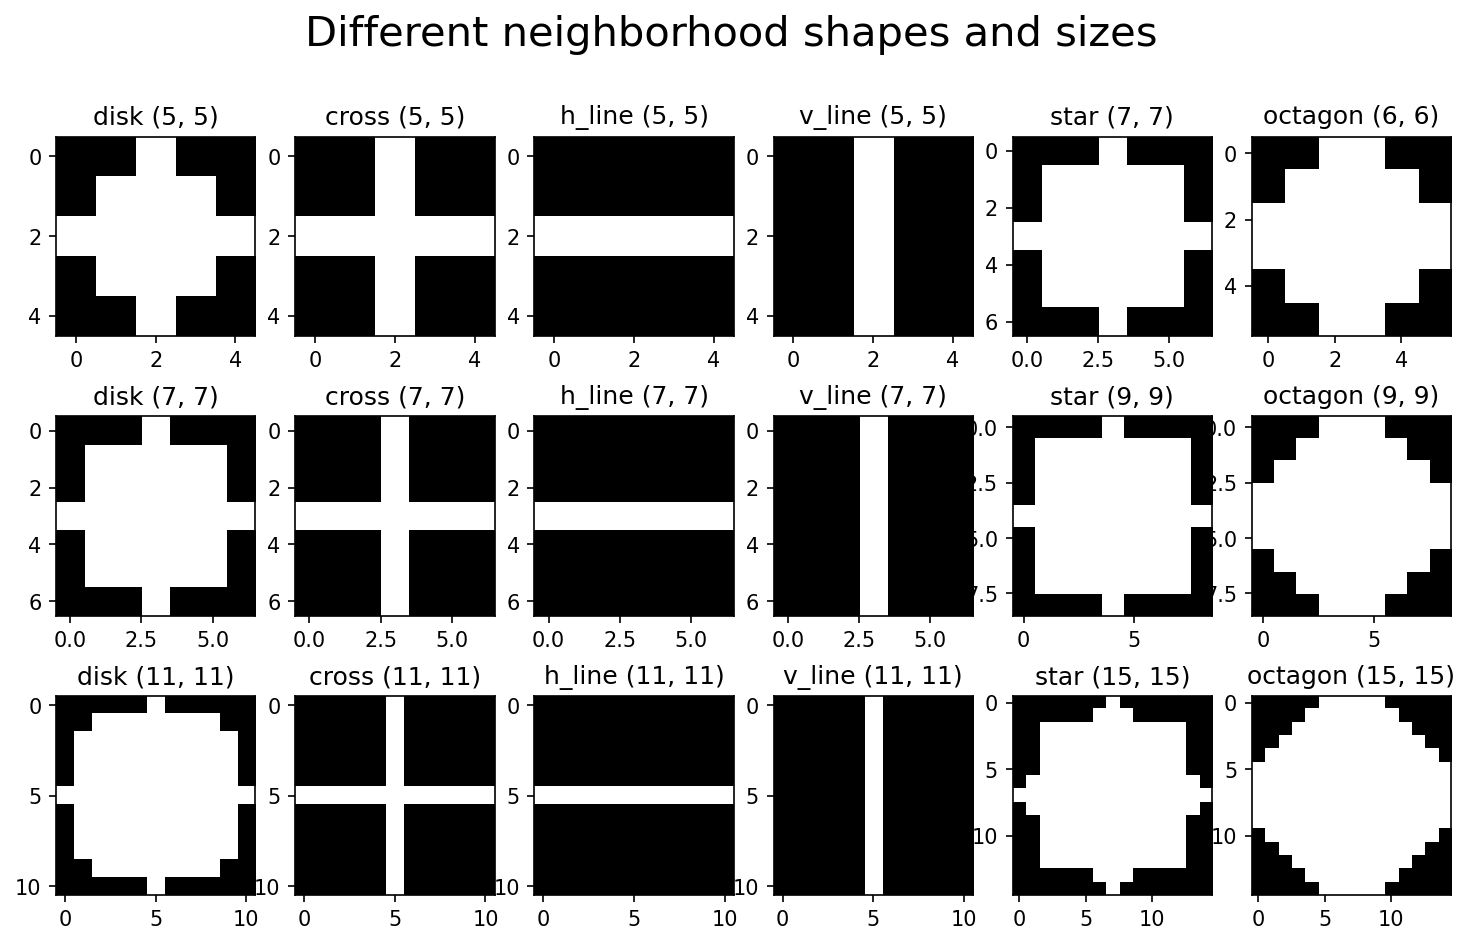

In [34]:
neighbor_functions = [disk, cross, h_line, v_line, star, octagon]
sizes = [2, 3, 5]
fig, m_axs = plt.subplots(len(sizes),len(neighbor_functions),
                           figsize=(12, 7),dpi=150)
for c_dim, c_axs in zip(sizes, m_axs):
    for c_func, c_ax in zip(neighbor_functions, c_axs):
        c_ax.imshow(c_func(c_dim), cmap='bone', interpolation='none')
        c_ax.set_title('{} {}'.format(c_func.__name__, c_func(c_dim).shape))
        
plt.suptitle('Different neighborhood shapes and sizes', fontsize=20);

### Fundamentals: Neighbors in 3D

Neighborhoods in 3D include the planes above and below the center pixel in addition to the neighbors in the same plane. 

```{figure} figures/se_r1.pdf
---
scale: 25%
---
6-connected pixel neighborhood for 2D images.
```

```{figure} figures/se_rsqrt2.pdf
---
scale: 25%
---
8-connected pixel neighborhood for 2D images.
```

<table>
<tr>
<th>6-connected</th>
<th>26-connected</th>    
</tr>
<tr>
<td><img src="figures/6conn3d.svg" style="width:150px"/></td>
<td><img src="figures/26conn3d.svg" style="width:150px"/></td>
</tr>
</table>

## Erosion and Dilation

__Erosion__

If any of the voxels in the neighborhood are 0/false than the voxel will be set to 0

- Has the effect of peeling the surface layer off of an object

__Dilation__

If any of the voxels in the neigbhorhood are 1/true then the voxel will be set to 1
- Has the effect of adding a layer onto an object (dunking an strawberry in chocolate, adding a coat of paint to a car)

### Applied Erosion and Dilation

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph

s=255.0
cmap = [[230/s,230/s,230/s],
        [255/s,176/s,159/s],
        [0.0/s,0.0/s,0.0/s]]

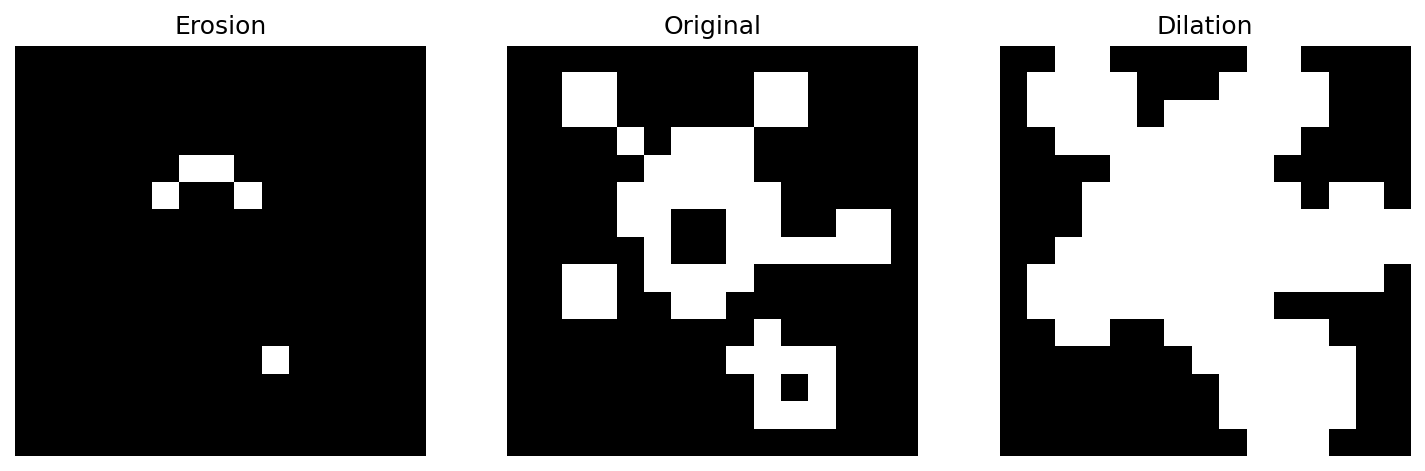

In [40]:
img=np.load('data/morphimage.npy')

dimg=morph.dilation(img,[[0,1,0],[1,1,1],[0,1,0]])
eimg=morph.erosion(img, [[0,1,0],[1,1,1],[0,1,0]])

fig, ax = plt.subplots(1,3,figsize=(12,6),dpi=150)

ax[0].imshow(eimg,cmap='gray'); ax[0].set_title('Erosion'),  ax[0].axis('off');
ax[1].imshow(img,cmap='gray');  ax[1].set_title('Original'), ax[1].axis('off');
ax[2].imshow(dimg,cmap='gray'); ax[2].set_title('Dilation'), ax[2].axis('off');

#### Dilation
We can use dilation to expand objects, for example a too-low threshold value leading to disconnected components

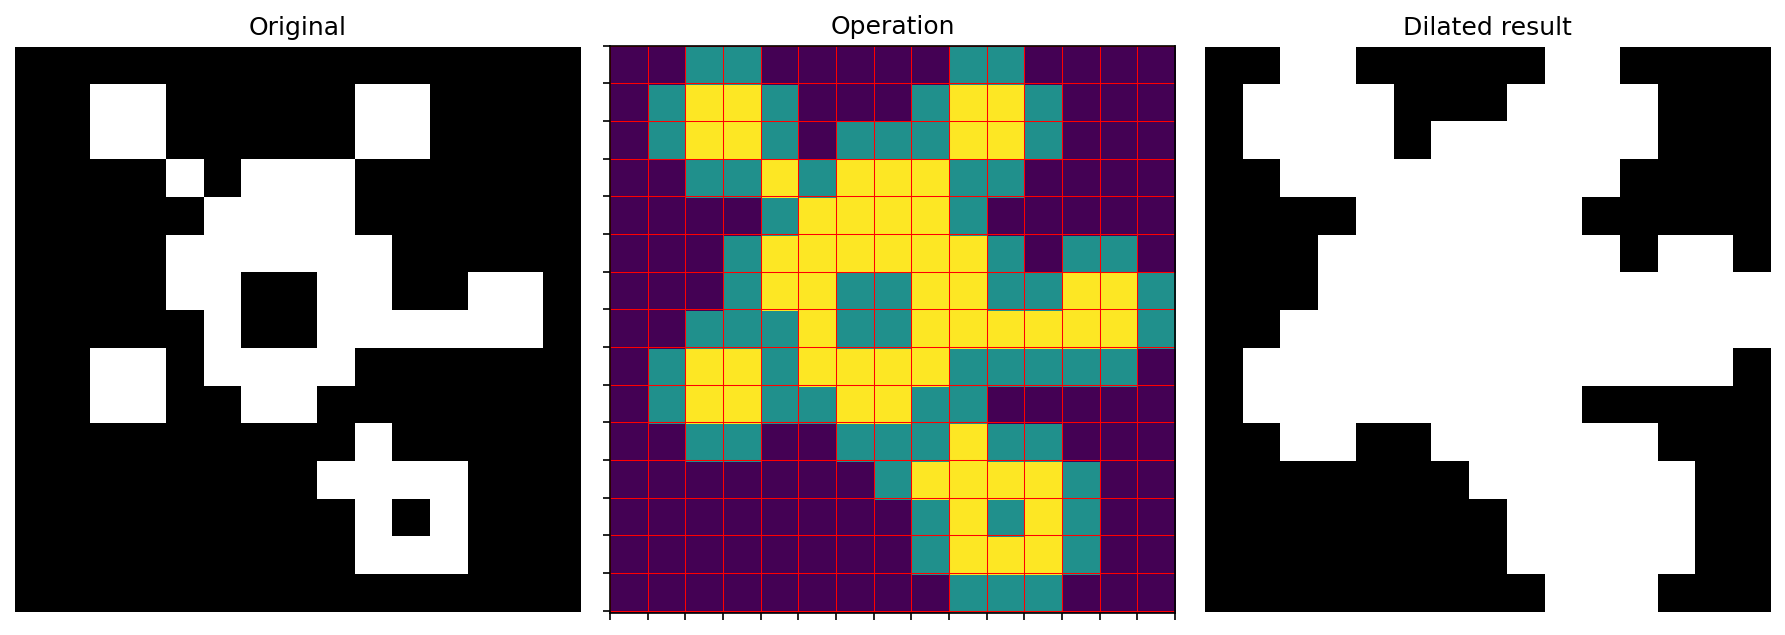

In [46]:
dimg=morph.dilation(img,[[0,1,0],[1,1,1],[0,1,0]])

fig, ax = plt.subplots(1,3,figsize=(12,6), dpi=150)

ax[0].imshow(img,cmap='gray'); ax[0].set_title('Original'); ax[0].axis('off');

ax[1].imshow(img+dimg,cmap='viridis'); 
ax[1].set_xticks(np.arange(-0.5,img.shape[1],1)); ax[1].set_xticklabels([]);ax[1].set_yticks(np.arange(-0.55,img.shape[0],1)); ax[1].set_yticklabels([]) 
ax[1].grid(color='red', linestyle='-', linewidth=0.5); ax[1].grid(True);ax[1].set_title('Operation')

ax[2].imshow(dimg,cmap='gray'); ax[2].set_title('Dilated result');ax[2].axis('off');
plt.tight_layout()

#### Erosion
Erosion performs the opposite task to the dilation by reducing the size of the objects in the image

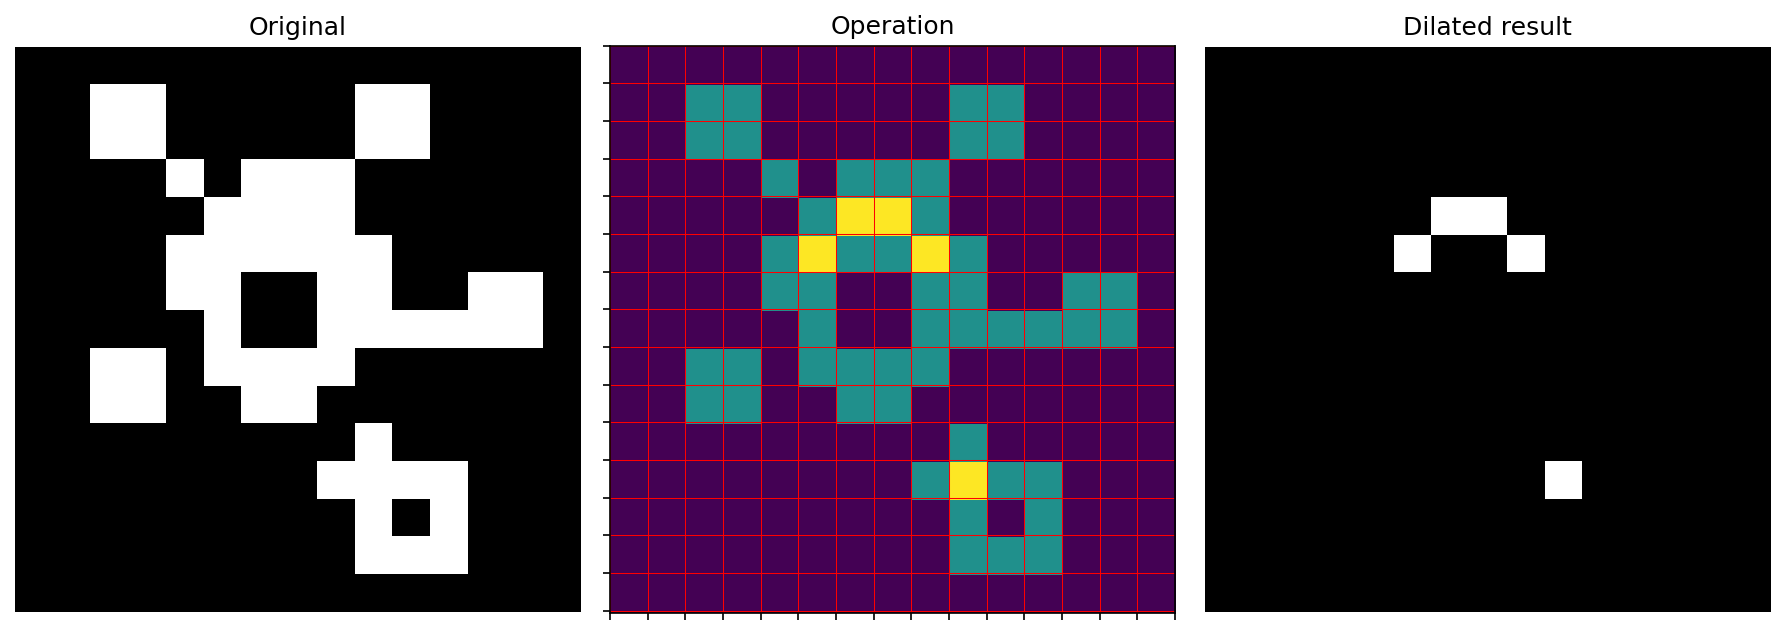

In [47]:
eimg=morph.erosion(img,[[0,1,0],[1,1,1],[0,1,0]])
fig, ax = plt.subplots(1,3,figsize=(12,6),dpi=150)

ax[0].imshow(img,cmap='gray'); ax[0].set_title('Original'); ax[0].axis('off');

ax[1].imshow(img+eimg,cmap='viridis'); 
ax[1].set_xticks(np.arange(-0.5,img.shape[1],1)); ax[1].set_xticklabels([]);ax[1].set_yticks(np.arange(-0.55,img.shape[0],1)); ax[1].set_yticklabels([]) 
ax[1].grid(color='red', linestyle='-', linewidth=0.5); ax[1].grid(True);ax[1].set_title('Operation')

ax[2].imshow(eimg,cmap='gray'); ax[2].set_title('Dilated result');ax[2].axis('off');
plt.tight_layout()

## Opening and Closing

Erosion and dilation removes and adds a layer of pixels to the objects in the image.

This is not desired, combining them gives two new operations:
- Opening $\delta(\epsilon(f))$

- Closing $\epsilon(\delta(f))$

These operation rebuilds most of the objects after removing unwanted features.

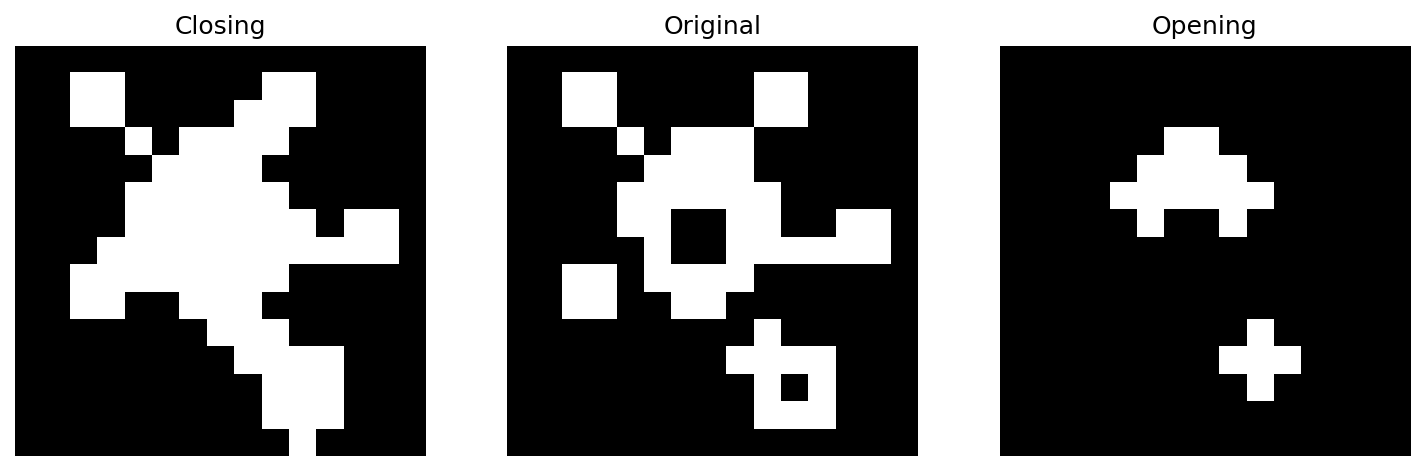

In [48]:
oimg = morph.opening(img,np.array([[0,1,0],[1,1,1],[0,1,0]]))
cimg = morph.closing(img,np.array([[0,1,0],[1,1,1],[0,1,0]]))

fig, ax = plt.subplots(1,3,figsize=(12,6), dpi=150)
ax[0].imshow(cimg,cmap='gray'); ax[0].set_title('Closing'), ax[0].axis('off');
ax[1].imshow(img,cmap='gray'); ax[1].set_title('Original'), ax[1].axis('off');

ax[2].imshow(oimg,cmap='gray'); ax[2].set_title('Opening'), ax[2].axis('off');

### Morphological Closing 

A dilation followed by an erosion operation

$$\epsilon(\delta(f))$$

- Adds a layer and then peels a layer off
- Objects that are very close are connected when the layer is added and they stay connected when the layer is removed thus the image is __close__d
- A cube larger than one voxel will have the exact same volume after (conservative)

Closing is an operation you apply to remove false negatives in your image. The effect is that small holes in the objects are filled and gaps between large objects are connected.

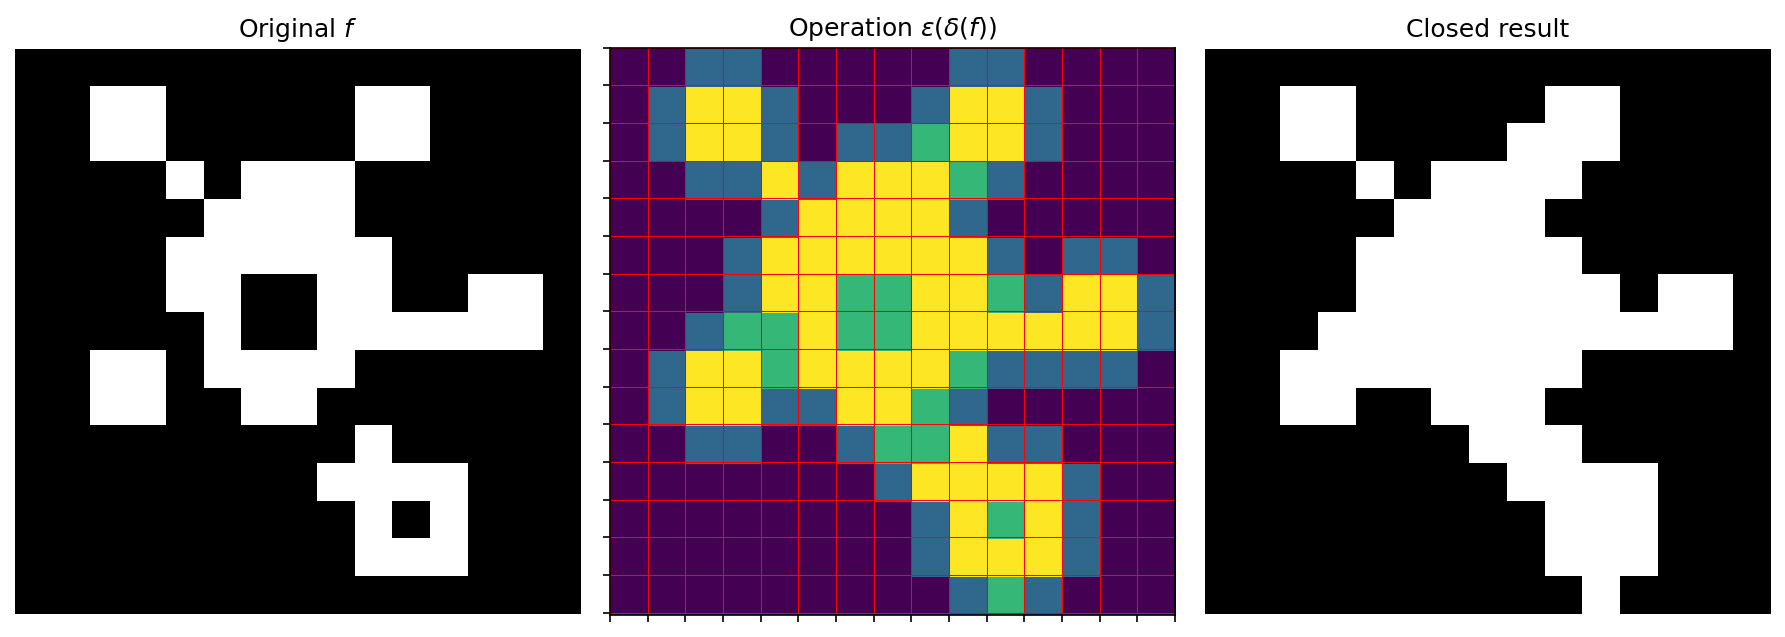

In [49]:
fig, ax = plt.subplots(1,3,figsize=[12,6], dpi=150)

ax[0].imshow(img,cmap='gray'); ax[0].set_title('Original $f$') ; ax[0].axis('off');

ax[1].imshow(img+dimg+cimg,cmap='viridis'); ax[1].set_title('Operation $\epsilon(\delta(f))$')
ax[1].set_xticks(np.arange(-0.5,img.shape[1],1));  ax[1].set_xticklabels([]); 
ax[1].set_yticks(np.arange(-0.55,img.shape[0],1)); ax[1].set_yticklabels([]); 
ax[1].grid(color='red', linestyle='-', linewidth=0.5); ax[1].grid(True)

ax[2].imshow(cimg,cmap='gray'); ax[2].axis('off')
ax[2].set_title('Closed result');
plt.tight_layout()

### Morphological opening

An erosion followed by a dilation operation
$$\delta(\epsilon(f))$$

- Peels a layer off and adds a layer on
- Very small objects and connections are deleted in the erosion and do not return the image is thus __open__ed
- A cube larger than several voxels will have the exact same volume after (conservative)

Opening is an operation you apply to remove false positives in your image. The effect is that small objects are erased and connections between large objects are removed.

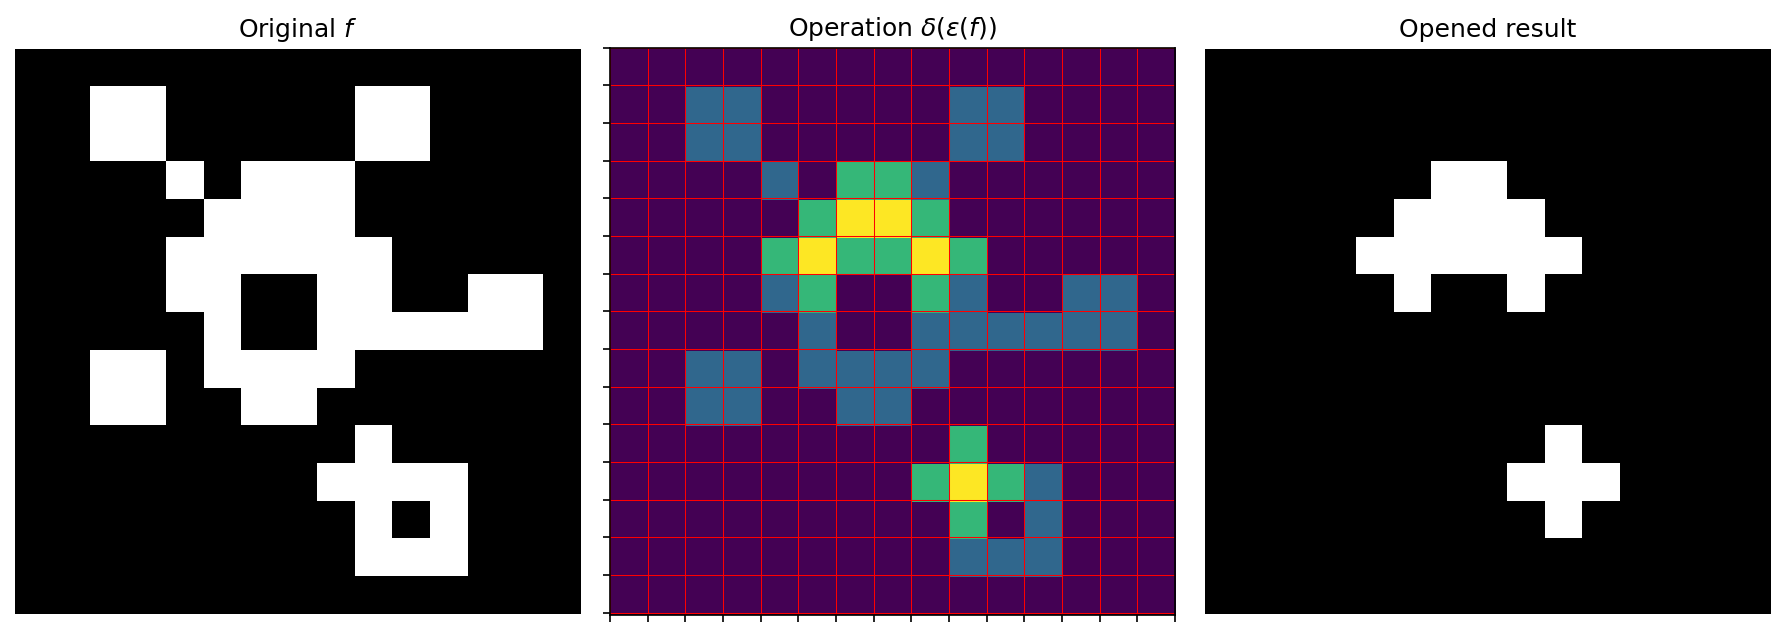

In [50]:
fig,ax = plt.subplots(1,3,figsize=[12,6],dpi=150)

ax[0].imshow(img,cmap='gray'); ax[0].axis('off');
ax[0].set_title('Original $f$')

ax[1].imshow(img+eimg+oimg,cmap='viridis'); ax[1].set_title('Operation $\delta(\epsilon(f))$')
ax[1].set_xticks(np.arange(-0.5,img.shape[1],1)); ax[1].set_xticklabels([])
ax[1].set_yticks(np.arange(-0.55,img.shape[0],1)); ax[1].set_yticklabels([])
ax[1].grid(color='red', linestyle='-', linewidth=0.5); ax[1].grid(True)

ax[2].imshow(oimg,cmap='gray'); ax[2].axis('off')
ax[2].set_title('Opened result')

plt.tight_layout()

# Pitfalls with Segmentation

## Partial Volume Effect
- The [partial volume effect](http://bit.ly/1mW7kdP) is the name for the effect of discretization on the image into pixels or voxels.
- Surfaces are complicated, voxels are simple boxes which make poor representations
- Many voxels are only partially filled, but only the voxels on the surface
- Removing the first layer alleviates issue


## Thresholding structures
What happens when we threshold objects of different sizes?

In this example we create a series of spheres on different grid sizes form 10 up to 500 pixels.

In [168]:
from scipy.ndimage import zoom
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline

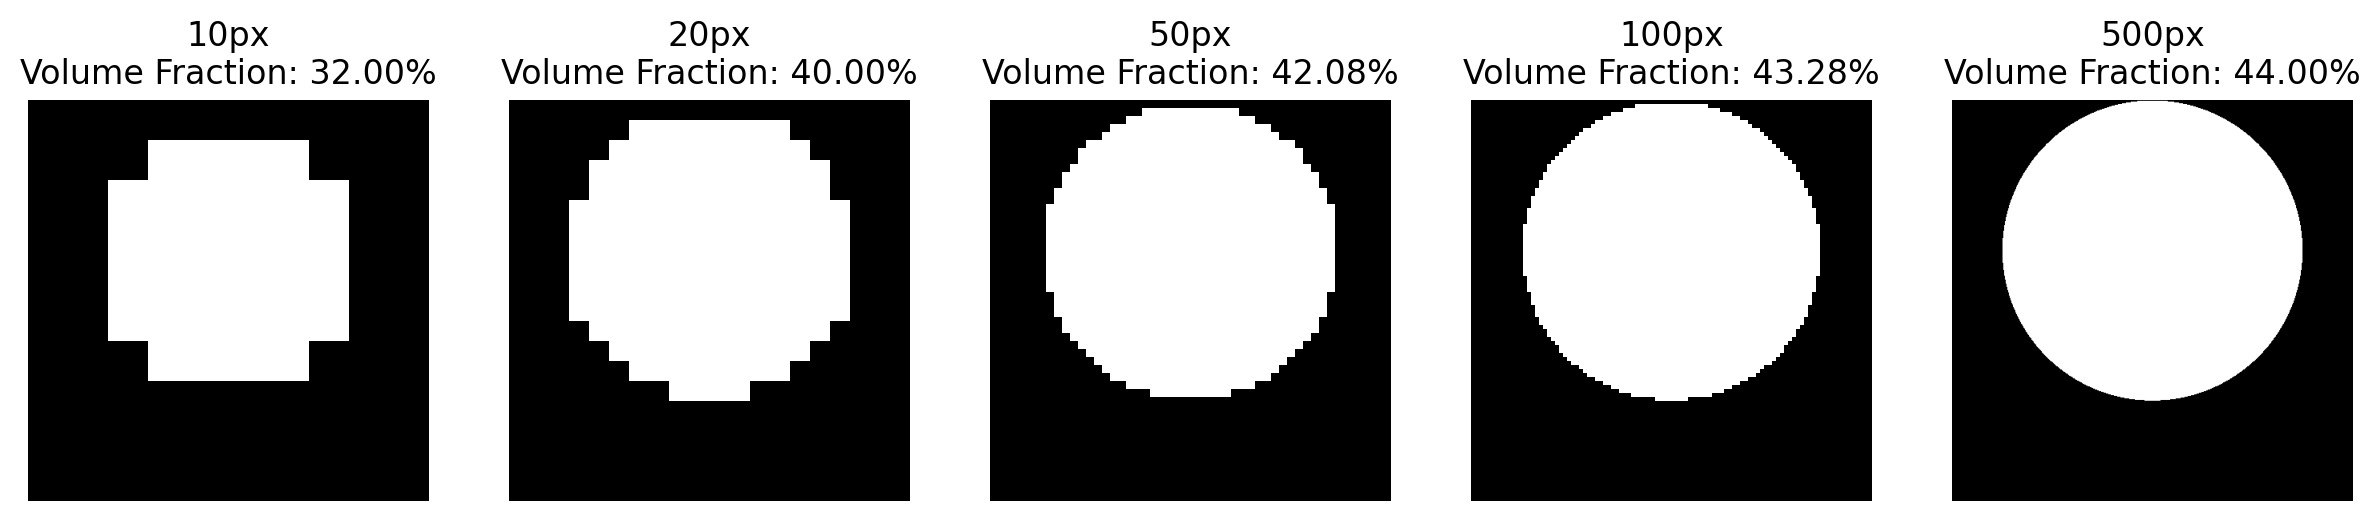

In [169]:
step_list  = [10, 20, 50, 100, 500]
fig, m_axs = plt.subplots(1, len(step_list), figsize=(15, 5), dpi=200)
for c_ax, steps in zip(m_axs, step_list):
    x_lin    = np.linspace(-1, 1, steps)
    xy_area  = np.square(np.diff(x_lin)[0])
    xx, yy   = np.meshgrid(x_lin, x_lin)
    test_img = (np.square(xx)+np.square(yy+0.25)) < np.square(0.75)
    c_ax.imshow(test_img,cmap='gray')
    c_ax.set_title('%dpx\nVolume Fraction: %2.2f%%' %
                   (steps, 100*np.sum(test_img)/np.prod(test_img.shape)))
    c_ax.axis('off')

Here you can see that the small objects are very pixeled and almost doesn't resemble a disk. When object size increases we see that the object looks more and more like a round disk. We also see that the volume fraction increases towards the value the resembles the volume of a true disc.

## When is a sphere really a sphere?

We just saw that a 2D disc can be very pixelated for small radii. The same applies in 3D. In this example, you can see what a sphere looks like. The first two examples doesn't really look like a sphere, while the last one starts to look like a sphere. The plot in the last panel shows the volume error for different discrete spheres. At a raduis of about 10 pixels the error is below one percent. 

```{figure} figures/sphere_comparison.pdf
---
scale: 100%
---
Discrete spheres with increasing radius.
```

<img src="figures/sphere_comparison.svg" />  
$$V_{error} = \frac{V_{discrete}}{V_{Analytical}}$$

What we are learning from this study is that there is a difference between detecting a basic feature and really representing it true shape. Detection should in principle be posible withing a few pixels if the SNR is sufficiently high.

## Rescaling

Sometimes, we want to downscale the image when it is too large. This is mostly done due to problems of fitting the images into memory or to speed up the processing. Rescaling should generally be done on gray scale images to avoid visible partial volume effects, which means that pixels done have only two values anymore at the edges.

In this example we rescale images from 500x500 down to 15x15 that the apparent volume fraction changes at the edges in some positions.

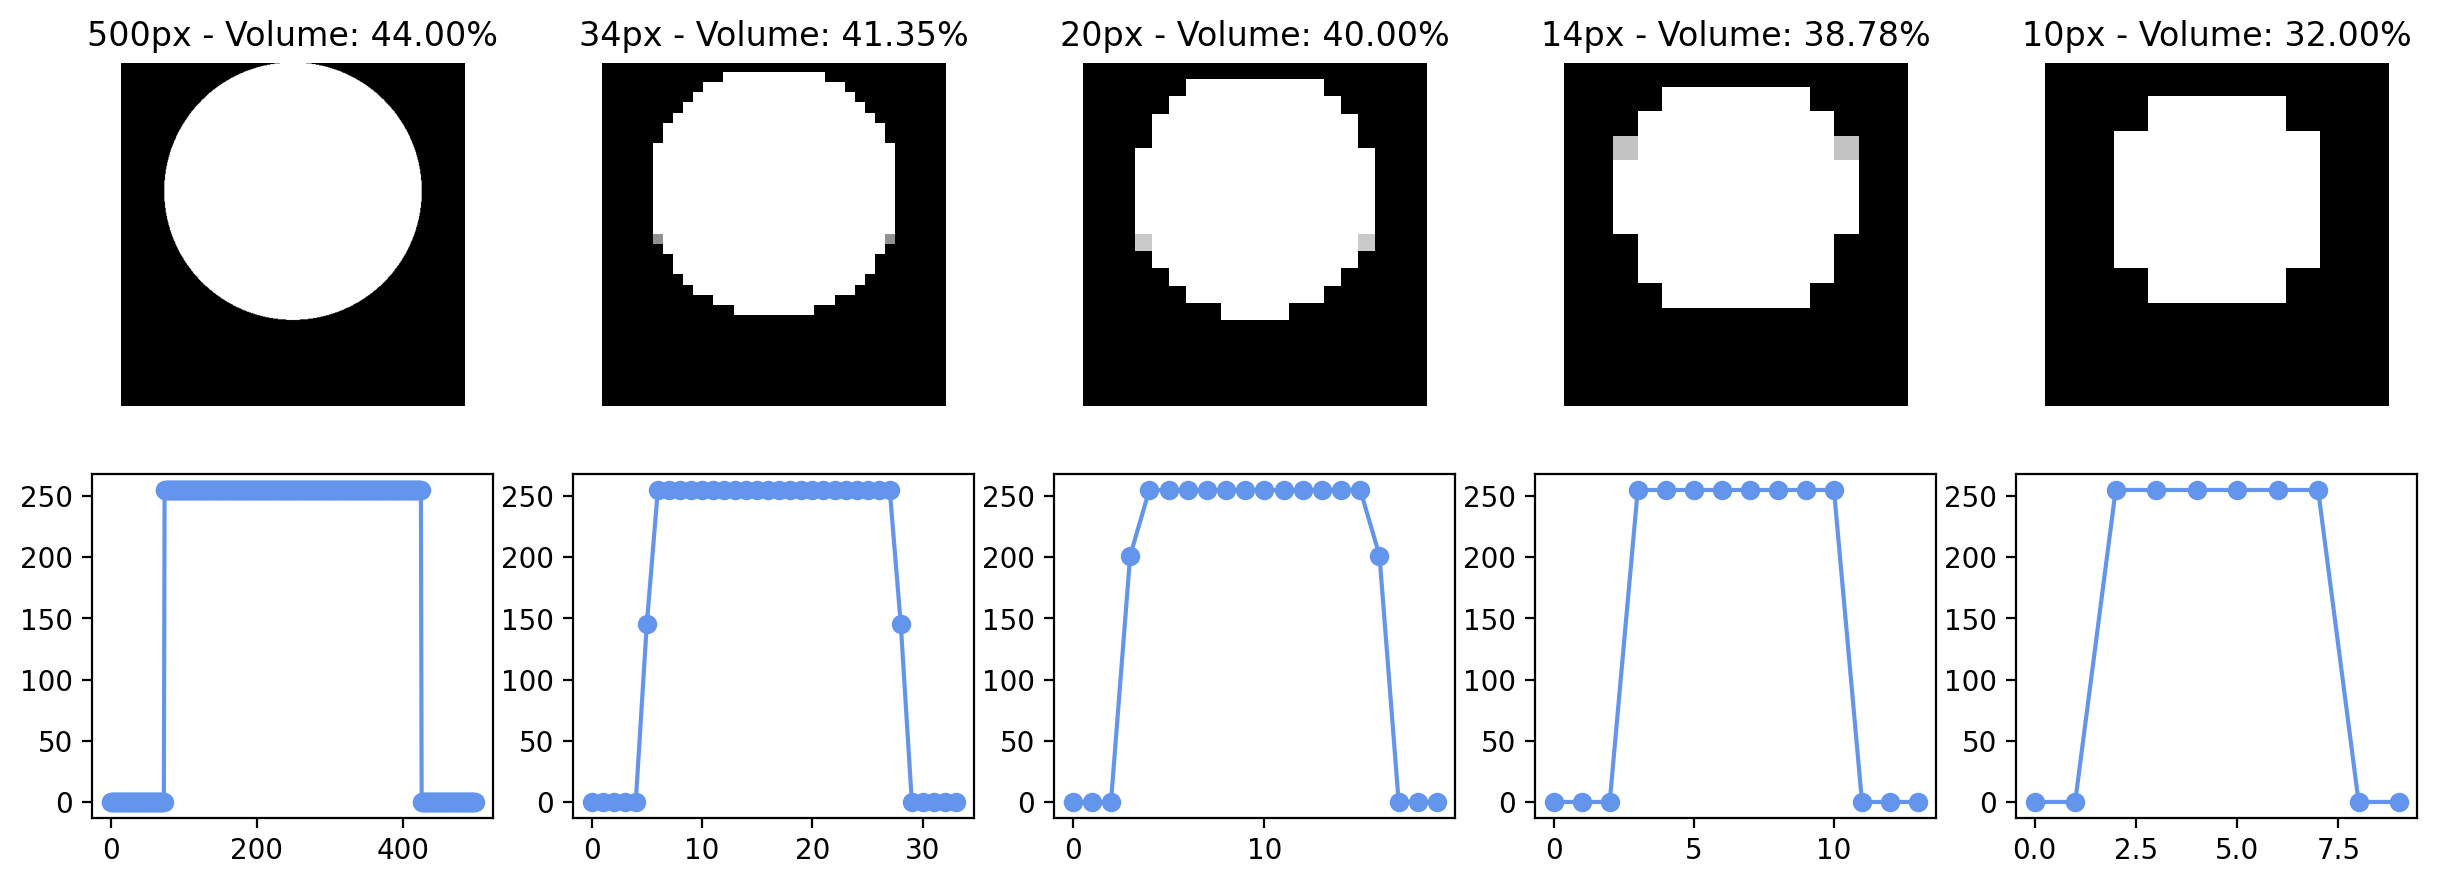

In [170]:
zoom_level = [1, 0.067, 0.039, 0.029, 0.02]
fig, m_axs = plt.subplots(2, len(zoom_level), figsize=(15, 5), dpi=200)
for (c_ax, ax2), c_zoom in zip(m_axs.T, zoom_level):
    c_img = zoom(255.0*test_img, c_zoom, order=1)
    c_ax.imshow(c_img,cmap='gray')
    c_ax.set_title('%dpx - Volume: %2.2f%%' %
                   (c_img.shape[0], 100*np.sum(c_img > 0.5)/np.prod(c_img.shape)))
    c_ax.axis('off')
    ax2.plot(c_img[c_img.shape[0]//2], 'o-', color='cornflowerblue')

The intermediate values are in particular visible in the profiles from down sizing from 500 pixel to 20 and 34 pixels.

# Summary

In todays lecture we have looked into
- The image formation process and how it relates to the segmentation problem.
- How the histogram can be used to decide how to segment an image.
- Evaluation of segmentation performance.
- The basic operations of morphological image processing
    - Using morphological operations to clean up segmented images
- Pitfall with segmentation - partial volume effects.